# Challenge: Classification

In this challenge, you will use a quantum circuit as a classifier, to classify input data into two classes.



## Problem
The data will be 'classical', meaning that your circuit will receive quantum states which encode classical vectors as an input.

Depending on some property of these states, the classifier will decide whether they should receive the label '0', or '1'.

This can be achieved with variational circuits, and we can use the following as an [example](https://arxiv.org/abs/1802.06002).

The idea in this case is to use an 'ancilla' qubit which, when measured, will decide whether a given input gets classified as a zero or a one. 

In this simple example, we will be classifying binary strings, $z\in \{0, 1\}^n$. Each string will have a **true**
label, $l(z)$, and we want our classifier to try and approximate this function, $l$.

$n = 2$ for our purposes, so the true labels could be the following:

\begin{align}
z = z_1z_2 =  \begin{cases}
00 \implies l(z) = -1\\
01 \implies l(z) = +1\\
10 \implies l(z) = -1\\
11 \implies l(z) = +1\\
\end{cases}
\end{align}

# Quantum Neural Network
We will construct a rudimentary 'quantum neural network' which can classify.
The circuit has a structure liek the below, where a sequence of $L$ parameterised unitaries, $\mathcal{U}(\theta) = U_1(\theta_1)U_2(\theta_2)\dots U_L(\theta_L)$ act on the 'data' string, $z = z_1z_2$, which is encoded in a computational basis state, $|z_1z_2\rangle$. 

For example, the string $01$ would be encoded as the two qubit state, $|01\rangle$.

We also have an ancilla qubit, prepared in the $|1\rangle$ state, which we will measure.


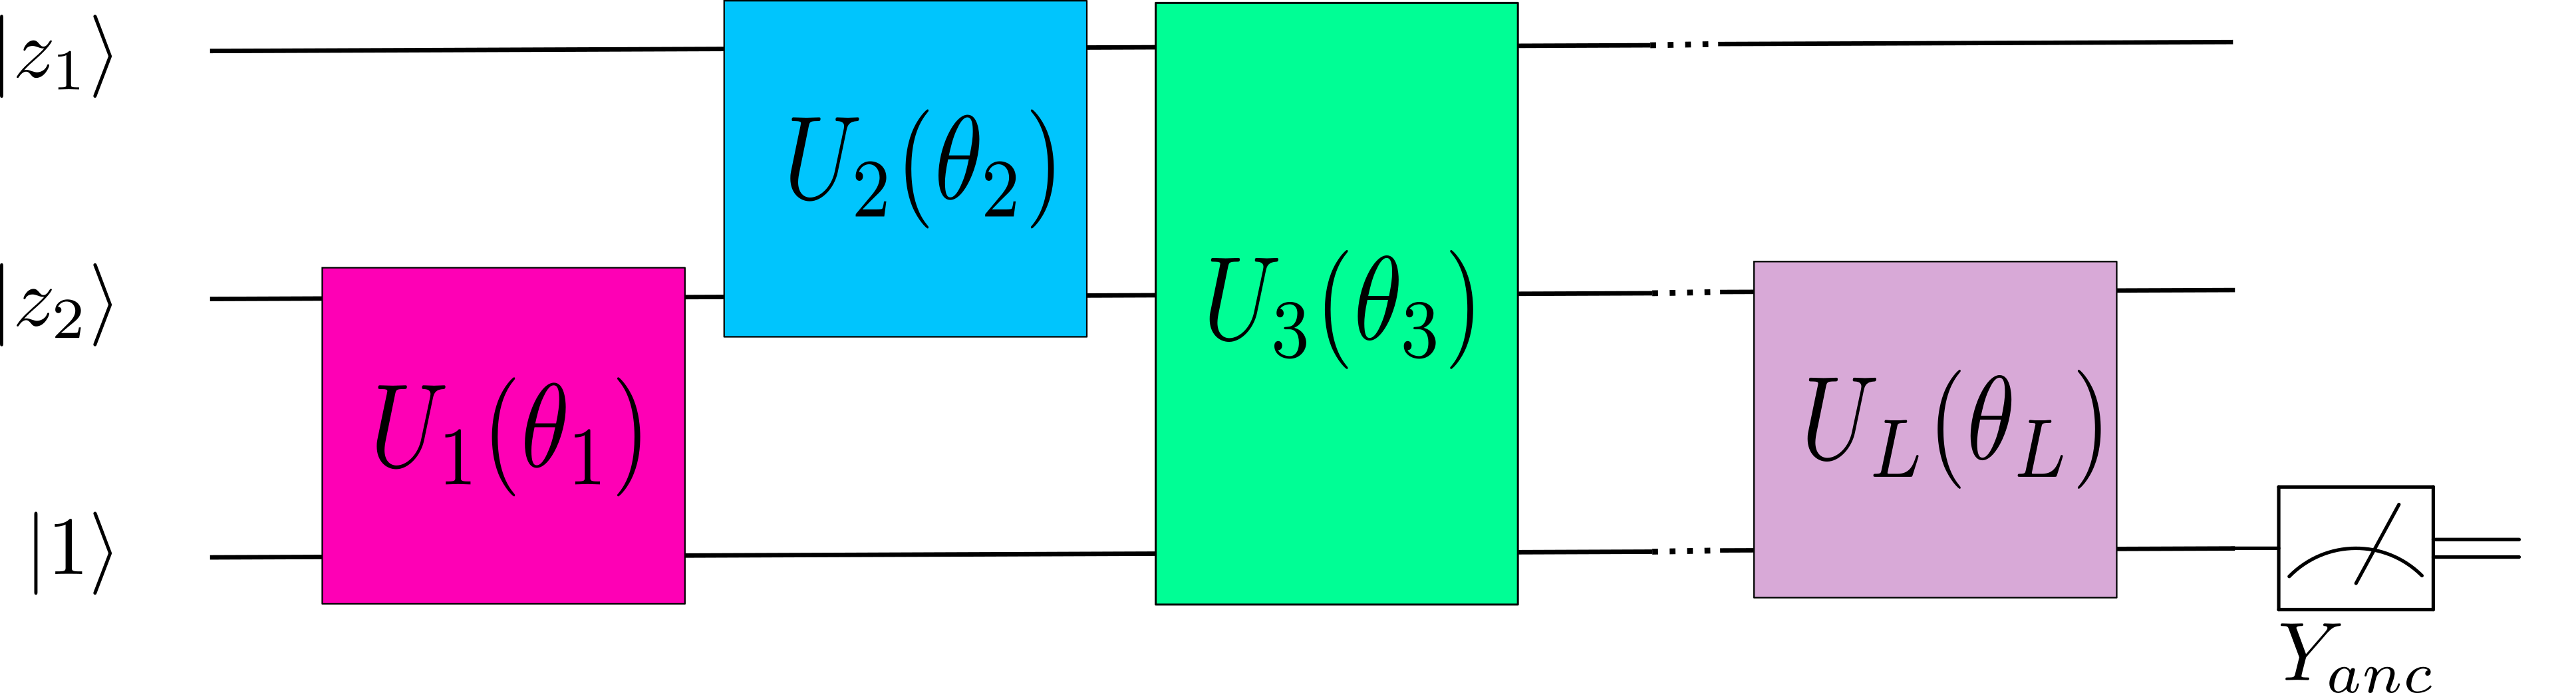

The measurement of a quantum state can behave like the 'non-linearity' present in neural neural networks, which is a key feature of the success of neural networks. 

We will use two qubits as the target, and the ancilla will be measured in the Pauli-'Y' basis:

\begin{align}
Y_{anc} = \left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}
\right)
\end{align}

By running the above circuit multiple times, and repeatedly measuring the ancilla in the Y basis, we can compute the following expectation value:

\begin{align}
\langle Y_{anc} \rangle = \langle z_1z_2, 1|\mathcal{U}(\theta)Y_{anc}\mathcal{U}(\theta)|z_1z_2, 1\rangle
\end{align}




## Loss function
The 'loss' function (per example string z) will be the difference between the expectation value of the ancilla when measured in the $Y$ basis, and the true label:
\begin{align}
    L(z) = 1 - l(z)\langle, z, 1|\mathcal{U}(\theta)Y_{anc}\mathcal{U}(\theta)|z, 1\rangle
\end{align}

If the value of the **true** label (say +1) is different than that of the measured one (say -1), then:
measured in the $Y$ basis, and the true label:

\begin{align}
   l(z)\langle, z, 1|\mathcal{U}(\theta)Y_{anc}\mathcal{U}(\theta)|z, 1\rangle = (+1)(-1) = -1
\end{align}

so the cost function will be at maximum. 

The minimum would be where the measured value and the true label are identical in which case:

\begin{align}
    l(z)\langle z, 1|\mathcal{U}(\theta)Y_{anc}\mathcal{U}(\theta)|z, 1\rangle = (\pm 1)(\pm 1) = 1
    \implies L(z) = 0
\end{align}


# First things first: Encoding

Define a function which takes as input a binary vector of length $n$, and prepares the input register of $n+1$ qubits as above. For now, we will assume this is a *list*, i.e. input the python list \[0,1,1\] $\rightarrow$ Prepare the  state $|011, 1\rangle$

*Hint: rememeber the ancilla is **always** prepared in the $|1\rangle$ state*

In [1]:
# Import the usual things
from pyquil import Program
from pyquil.api import get_qc, WavefunctionSimulator, local_qvm
from pyquil.gates import *
import numpy as np
import os, inspect, sys

import sys
sys.path.insert(0, 'tests/')

make_wf = WavefunctionSimulator()

Since we are just using three qubits, we can just use the **3q-qvm** as the Quantum Device:

In [2]:
qc_name = '3q-qvm'
with local_qvm():
    qc = get_qc(qc_name)

qubits = qc.qubits()

In [3]:
def classifier_input_prep(bitstring, qubits):
    n = len(bitstring)
    input_circuit = Program()
    for bit in range(n):
        if bitstring[bit] == 1:
            input_circuit += X(qubits[bit])
#     input_circuit += # Add gates
    return input_circuit

Now, to build the unitaries, we can restrict to only using single and two qubit unitaries which are parameterised.

For simplicity, we will apply one parameterised two-qubit gate between all pairs of qubits (we have 3 qubits so we can have 3(3-1)/2 = 3 combinations)
We will alos apply a single qubit parameterised gate to each

To start, we will use the following gate as our two qubit entangling parameterised gate::

$CPHASE(\theta_1)_{0, 1}$ applies a controlled phase to a two qubit state, by an angle $\theta$:

$CPHASE(\theta_1)_{0, 1} = \left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 &  0\\
0 & 0 & 0 &  e^{i\theta_1}
\end{array}
\right)$

$CPHASE(\theta_1)_{0, 1}|0\rangle|0\rangle = |0\rangle|0\rangle$
$CPHASE(\theta_1)_{0, 1}|1\rangle|0\rangle = |1\rangle|0\rangle$
$CPHASE(\theta_1)_{0, 1}|0\rangle|1\rangle = |0\rangle|1\rangle$
$CPHASE(\theta_1)_{0, 1}|1\rangle|1\rangle = e^{i\theta_1}|1\rangle|1\rangle$

We will use this gate since it is similar to the $CZ$ gate, which can be recovered by setting the parameter, $\theta_1 = \pi/2$:

Similarly, we use the $R_y$ gate instead of a Hadamard:

$R_y(\theta_2) = \left(\begin{array}{cc}
\cos(\frac{\theta}{2}) &  -\sin(\frac{\theta}{2})\\
 \sin(\frac{\theta}{2}) &  \cos(\frac{\theta}{2})
\end{array}
\right)$

For $\theta_2 = \frac{\pi}{2}$, we get a state which has a similar effect as the Hadamard gate.

Write a circuit which first applies $R_y(\theta)$ to all three qubits, and then applies $CPHASE(\theta)_{0,1}$ to all pairs of qubits. 

The input 'params' will be a numpy array of parameters which will be updated during the training phase.

In [4]:
def qnn_circuit_prep(input_circuit, params, qubits):
    if not isinstance(input_circuit, Program):
        raise TypeError('The input must be a Pyquil program')
    qnn_circuit = input_circuit
    
    qnn_circuit += RY(params[0], qubits[0])
    qnn_circuit += RY(params[1], qubits[1])
    qnn_circuit += RY(params[2], qubits[2])
    
    qnn_circuit += CPHASE(params[3], qubits[0], qubits[1])
    qnn_circuit += CPHASE(params[4], qubits[1], qubits[2])
    qnn_circuit += CPHASE(params[5], qubits[0], qubits[2])

    return qnn_circuit
    

Lets see what this circuit looks like:


In [5]:
# params = np.random.rand(6)
# # input_bitstring = [1, 0, 1]
# # input_circuit = classifier_input_prep(input_bitstring, qubits)

# print('The input preparation circuit is:\n', input_circuit)
# print('\nWhich for the input bitstring:\n', input_bitstring)

# with local_qvm():
#     wf = make_wf.wavefunction(input_circuit)
# print('\nAnd produces the state:\n', wf)

# qnn_circuit = qnn_circuit_prep(input_circuit, params, qubits)
# print('\nThe full circuit is:', qnn_circuit)


## Measurement

Now write a function which takes the circuit, and measures the ancilla in the Pauli - $Y$ basis.

You can just use the *run* function which requires defining memory.

num_trials is the number of measurement shots we do.


*Hint: Check out the measurement challenge to see how to measure in different bases than the computational basis*

In [6]:
def measure_ancilla(circuit, qc, qubits, num_trials):
    if not isinstance(circuit, Program):
        raise TypeError('The input must be a Pyquil program')
        
    circuit += PHASE(np.pi/2, qubits[2])
    circuit += H(qubits[2])
    
    ro = circuit.declare('ro', 'BIT', 1)
    
    circuit += MEASURE(qubits[-1], ro[0])
    circuit.wrap_in_numshots_loop(num_trials)
    executable = qc.compile(circuit)
    measurement_results =  qc.run(executable)
    
    return measurement_results



Finally, now that we have built the classifier circuit, it is time to define the cost function and optimise the parameters of the circuit.

Firstly, define a function which computes the expectation value $\langle Y_{anc}\rangle$. This will just be the difference between the number of '0's we measure from the ancilla, versus the number of '1's we see.


In [7]:
def compute_expectation(results, qubits):
    prob_zero = list(results).count([0])/num_trials 
    prob_one = list(results).count([1])/num_trials 
    
    expectation_value = prob_zero - prob_one
    return expectation_value

# num_trials = 10000

# input_circuit = classifier_input_prep(input_bitstring, qubits)
# qnn_circuit = qnn_circuit_prep(input_circuit, params, qubits)

# results = measure_ancilla(qnn_circuit, qc, qubits, num_trials)
# expectation_value = compute_expectation(results, qubits)
# expectation_value

Next, define the loss function itself.

We can use the empirical loss, which is the average over all $N$ sample points of the per-sample loss:

\begin{align}
EL = \frac{1}{\text{N}}\sum_{i=0}^N l(z^i)
\end{align}

where $l(z^i)$ is the loss for **sample i**. *Note: i is **NOT** the index of a bit in the bitstring z (which we denote as $z_i$), instead it is the index of the bitstring itself in our list of samples.*

In [8]:
def classifier_loss(params, samples, labels, qc, num_trials):
    N = len(samples)
    loss_per_sample = np.zeros(N)
    for sample in range(N):
        input_circuit = classifier_input_prep(samples[sample], qubits)
        qnn_circuit = qnn_circuit_prep(input_circuit, params, qubits)

        results = measure_ancilla(qnn_circuit, qc, qubits, num_trials)
        expectation_value = compute_expectation(results, qubits)
        
        loss_per_sample[sample] = 1 - labels[sample]*expectation_value
#         print(labels[sample], expectation_value)
    loss = (1/N)*np.sum(loss_per_sample)
    print(loss)
    return loss
# params = np.random.rand(6)

# samples = [[0,1], [0,0]] 
# labels = [+1, -1]
# num_trials = 1000
# classifier_loss(params, samples, labels, qc, num_trials)

Let's say we define our ***true*** label function as above:

\begin{align}
z = z_1z_2 =  \begin{cases}
00 \implies l(z) = +1\\
01 \implies l(z) = +1\\
10 \implies l(z) = -1\\
11 \implies l(z) = -1\\
\end{cases}
\end{align}



Let's generate some samples according to this function:


In [9]:
import random
def generate_samples(N_samples, n_bits):
    samples = [[random.randint(0,1) for bit in range(n_bits)] for sample in range(N_samples)]
    labels = []

    for sample in samples:
        if sample[0] == 0:
            labels.append(+1) # Fill labels array with correct labels
        else: labels.append(-1)

    return samples, labels

In [ ]:
import scipy.optimize as opt
N_samples = 10
n_bits = 2
params = np.random.rand(6)
num_trials = 100

samples, labels = generate_samples(N_samples, n_bits)
result =  opt.minimize(classifier_loss, params, args=(samples, labels, qc, num_trials), method='Powell')
print(result)

0.9980000000000001
0.918
1.016
0.97
0.9159999999999999
0.9960000000000001
0.9300000000000002
0.91
0.9299999999999999
0.938
0.932
0.9640000000000001
0.9199999999999999
0.9380000000000002
0.968
0.9420000000000001
0.9
0.9299999999999999
0.972
0.886
0.9199999999999999
0.9139999999999999
0.9640000000000001
0.9400000000000001
0.9420000000000002
0.886
0.8780000000000001
0.9340000000000002
0.8960000000000001
0.964
0.952
0.954
1.04
0.9900000000000001
0.976
0.978
1.05
0.9600000000000002
1.008
1.016
0.9359999999999999
0.9060000000000001
0.9640000000000001
0.932
0.9300000000000002
0.916
0.9199999999999999
0.972
0.9819999999999999
0.9740000000000001
0.9159999999999999
1.002
0.954
0.976
0.934
1.006
0.9480000000000001
0.9360000000000002
0.9240000000000003
0.968
0.9720000000000001
0.8980000000000001
0.934
0.938
0.9700000000000002
0.9819999999999999
0.9860000000000002
0.9820000000000001
0.916
0.9780000000000002
1.006
0.932
0.9359999999999999
1.0220000000000002
0.9119999999999999
